<center><h1>Optimizing Hyperparameters 2</h1>
John Ignacio R.M. 30 Jun 2020</center>

In [1]:
#ada library
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.data import read_dataset, split_dataset
from ada2.model import BinClassifModel3 as BC3
from ada2.plot import plot_confidence_matrix
import pandas as pd
from os.path import exists

#keras
from keras.optimizers import adam, adadelta, adagrad, adamax
from keras.backend import clear_session
import gc

Using TensorFlow backend.
Welcome to JupyROOT 6.20/04


In [2]:
source_path = "../processed_data/xtohh"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420

In [3]:
#read xtohh dataset SR 2
df = read_dataset(source_path, signal, bg, "SR", 2)
df

,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.001020,1,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.887240,1631.67020,263.697630
1,0.001117,1,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.033330,1293.40280,463.512360
2,0.000925,1,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.559220,1659.84830,80.008150
3,0.001158,1,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.607220,1075.30920,109.524925
4,0.001120,1,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.350300,1595.76110,244.283460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,0.006433,0,402.06714,0.109710,-1.277847,68576.34,486.71262,-0.060529,1.469456,120999.410,2.747302,2.752572,-0.883233,84.210686,891.92240,192.862270
8802,0.004849,0,542.29900,1.579771,-2.624035,84161.26,411.07132,1.205967,0.438185,56194.777,3.062220,3.084951,-0.216563,59.169407,970.41110,136.471160
8803,0.004849,0,548.63104,-0.033452,2.621298,79095.04,416.03915,0.336025,-0.553298,70408.830,3.108589,3.130470,-0.352454,34.371227,983.20233,133.526060
8804,0.007816,0,683.98340,-0.029910,-0.760806,110728.80,609.47140,0.094448,2.401307,148632.220,3.121072,3.123549,0.351719,55.616740,1320.47700,75.680750


In [4]:
lrs = [5e-3, 1e-2, 5e-2, 1e-1]
optis = [adam, adadelta, adagrad, adamax]
activs = ["relu", "softplus"]

splits = [
    (0.6, 0.2, 0.2), (0.5, 0.3, 0.2), #80:20
    (0.5, 0.2, 0.3), (0.4, 0.3, 0.3), #70:30
    (0.4, 0.2, 0.4), (0.3, 0.3, 0.4), #60:40
]

sets = [split_dataset(df, *split, seed) for split in splits]
ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

combs = [(sets[i], splits[i], lr, opti, acti) for i in range(len(splits))
                                                        for lr in lrs
                                                            for opti in optis
                                                                for acti in activs]
len(combs)

192

In [5]:
def f1_hyperparams(BC, sets, split, lr, opti, acti, ths, comb_id, epochs, dest_path):

    print(f"Comb {comb_id}:", split, lr, opti, acti)
    model = BC(sets["x"]["test"].shape[1], lr, opti, acti)

    if not exists(f"{dest_path}/{model.model_name}_t2_comb{comb_id}.h5"):
        print("[ ] Training...")
        model.fit(
            sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
            sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
            epochs, verbose = 0,
        )
        print("[~] Succesful training"); print("[ ] Saving...")
        model.save(dest_path, f"t2_comb{comb_id}")
        print("[~] Succesful saving")
    else:
        print("[ ] Loading...")
        model.load(dest_path, f"t2_comb{comb_id}")
        print("[~] Succesful loading")

    f1_per_th = pd.DataFrame.from_dict({th: model.f1(
                        sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], th,
                    ) for th in ths}, orient="index", columns = [0, 1, "wavg"])

    clear_session()
    gc.collect()
    del model
    
    return f1_per_th

In [6]:
def all_hyperparams_comb(combs, epochs, dest_path = "../saved_models/tun_hyperparams_2"):
    #get models and f1s
    n_combs = len(combs)
    f1_per_comb = [f1_hyperparams(BC3, *combs[i], ths, i, epochs, dest_path) for i in range(n_combs)]
    f1_per_comb = pd.concat(f1_per_comb, keys=range(n_combs), names = ["comb", "th"])
    return f1_per_comb

In [7]:
f1_per_comb = all_hyperparams_comb(combs, 50)

uccesful training
[ ] Saving...
[~] Succesful saving
Comb 102: (0.4, 0.3, 0.3) 0.005 <class 'keras.optimizers.Adamax'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 103: (0.4, 0.3, 0.3) 0.005 <class 'keras.optimizers.Adamax'> softplus
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 104: (0.4, 0.3, 0.3) 0.01 <class 'keras.optimizers.Adam'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 105: (0.4, 0.3, 0.3) 0.01 <class 'keras.optimizers.Adam'> softplus
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 106: (0.4, 0.3, 0.3) 0.01 <class 'keras.optimizers.Adadelta'> relu
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 107: (0.4, 0.3, 0.3) 0.01 <class 'keras.optimizers.Adadelta'> softplus
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 108: (0.4, 0.3, 0.3) 0.01 <class 'keras.optimizers.Adagrad'> rel

In [32]:
f1_per_comb.nlargest(15, ["wavg", 0, 1])

0         1      wavg
comb th                               
38   0.4  0.941052  0.987717  0.979862
     0.5  0.935101  0.986373  0.977743
     0.6  0.924504  0.983928  0.973925
46   0.3  0.914722  0.983294  0.971751
     0.4  0.913371  0.982999  0.971279
6    0.4  0.908484  0.981832  0.969485
46   0.5  0.906368  0.981454  0.968815
38   0.7  0.910138  0.980508  0.968663
12   0.6  0.902693  0.980323  0.967256
38   0.3  0.901005  0.980479  0.967101
46   0.6  0.901831  0.980116  0.966939
31   0.4  0.900238  0.980415  0.966919
23   0.5  0.899210  0.980523  0.966836
132  0.5  0.876655  0.981176  0.966828
129  0.4  0.873042  0.981419  0.966542

# Combination 38

In [21]:
combs[38][1:]

((0.5, 0.3, 0.2), 0.005, keras.optimizers.Adamax, 'relu')

In [22]:
sets_38 = combs[38][0]
model_38 = BC3(sets_38["x"]["test"].shape[1], 0.005, adamax, "relu")
model_38.load("../saved_models/tun_hyperparams_2", f"t2_comb38")

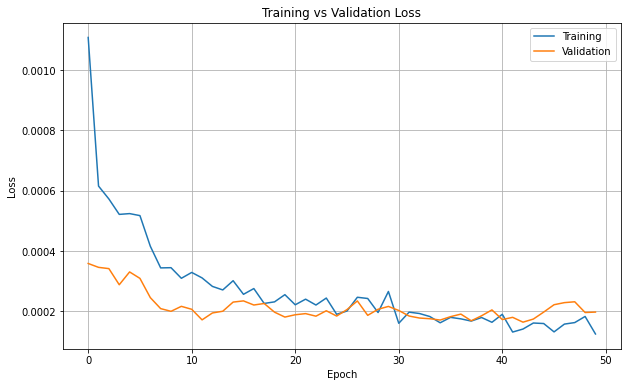

In [33]:
model_38.plot_loss()

In [24]:
eval_38 = model_38.complete_evaluation(
    sets_38["x"]["test"], sets_38["y"]["test"], sets_38["w"]["test"], 0.4,
)
print("Accuracy:", eval_38["accuracy"])

Accuracy: 0.9750283768444948


In [25]:
pd.DataFrame(eval_38["weighted_class_report"])

,0,1,macro avg,weighted avg
precision,0.919167,0.992642,0.955905,0.980274
recall,0.964005,0.982842,0.973423,0.979671
f1-score,0.941052,0.987717,0.964385,0.979862
support,0.392325,1.938392,2.330717,2.330717


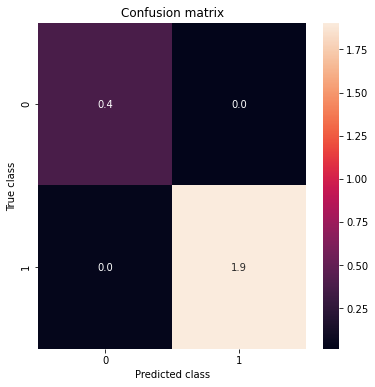

In [27]:
plot_confidence_matrix(eval_38["weighted_cm"], 6, 6, '.1f')

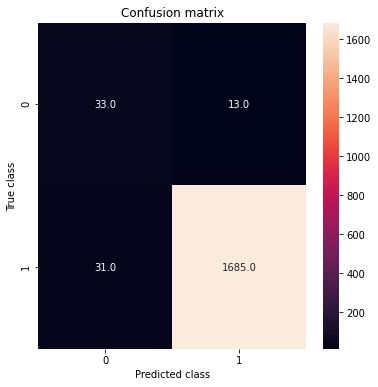

In [58]:
plot_confidence_matrix(eval_38["cm"], 6, 6, '.1f')